In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random, logging
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from scipy.optimize import differential_evolution
import random
from tensorflow import keras
import gym
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## **Algorithm Development**

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#### **configuration file for hyperparameters**

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "mutation_strategies": ['best1bin', 'rand1bin', 'rand2bin', 'currenttobest1bin', 'best1exp', 'rand1exp'],
    "crossover_strategies": ['bin', 'exp'],
    "cma_step_size": 0.3,
    "egt_max_size": 50,
    "dqn_learning_rate": 0.001,
    "max_generations": 100,
    "num_runs": 10,
    "batch_size": 32}

In [ ]:
# CMA-ES Implementation
class CMA:
    def __init__(self, dim, step_size=0.3):
        self.dim = dim
        self.mean = np.zeros(dim)
        self.cov_matrix = np.eye(dim)
        self.step_size = step_size

    def sample_population(self, size):
        try:
            return np.random.multivariate_normal(self.mean, self.cov_matrix * self.step_size, size)
        except np.linalg.LinAlgError:
            self.cov_matrix = np.eye(self.dim)
            self.step_size = 0.3
            return np.random.multivariate_normal(self.mean, self.cov_matrix * self.step_size, size)

    def update_covariance(self, population, fitness):
        fitness = np.asarray(fitness)
        if np.max(fitness) - np.min(fitness) == 0:
            return

        fitness = (fitness - np.min(fitness)) / (np.max(fitness) - np.min(fitness) + 1e-10)
        weights = np.exp(-fitness) / np.sum(np.exp(-fitness))

        if weights.ndim == 0:
            weights = np.array([weights])

        weighted_mean = np.sum(weights[:, None] * population, axis=0)
        centered_population = population - weighted_mean
        self.cov_matrix = np.cov(centered_population.T, aweights=weights)
        self.step_size *= np.exp(0.2 * (np.mean(fitness) - 1))

        if not np.all(np.linalg.eigvals(self.cov_matrix) > 0):
            self.cov_matrix = np.eye(self.dim)

# EGT-based Memory Archive
class EGTMemory:
    def __init__(self, max_size=50):
        self.solutions = []
        self.fitness = []
        self.max_size = max_size

    def add_solution(self, solution, fitness):
        if len(self.solutions) < self.max_size:
            self.solutions.append(solution)
            self.fitness.append(fitness)
        else:
            worst_idx = np.argmax(self.fitness)
            if fitness < self.fitness[worst_idx]:
                self.solutions[worst_idx] = solution
                self.fitness[worst_idx] = fitness

    def extract_patterns(self):
        return np.mean(self.solutions, axis=0) if self.solutions else None

# DQN Agent for Adaptive Strategy Selection
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def select_action(self, state):
        state = np.array(state).reshape(1, -1)
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in batch:
            target = reward + self.gamma * np.max(self.model.predict(np.array(next_state).reshape(1, -1), verbose=0))
            target_f = self.model.predict(np.array(state).reshape(1, -1), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.array(state).reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Adaptive Evolutionary Algorithm
class AdaptiveEA:
    def __init__(self, bounds, dim, objective_function):
        self.bounds = bounds
        self.dim = dim
        self.objective_function = objective_function
        self.agent = DQNAgent(state_size=1, action_size=len(CONFIG["mutation_strategies"]))
        self.egt_memory = EGTMemory()

    def evolve(self, generations=50):
        best_solution, best_fitness = None, float('inf')
        fitness_history = []  # Initialize a list to store fitness values
        strategies = CONFIG["mutation_strategies"]

        for generation in range(generations):
            strategy_idx = self.agent.select_action([generation])
            mutation_strategy = strategies[strategy_idx]

            result = differential_evolution(
                self.objective_function,
                bounds=self.bounds,
                strategy=mutation_strategy,
                recombination=0.7,
                popsize=20,
                tol=0.01,
                maxiter=1,
                disp=False)

            if result.fun < best_fitness:
                best_fitness = result.fun
                best_solution = result.x

            self.egt_memory.add_solution(result.x, result.fun)
            fitness_history.append(result.fun)

            reward = -result.fun
            next_state = [generation + 1]
            self.agent.memory.append(([generation], strategy_idx, reward, next_state))
            self.agent.train()

        mean_fitness = np.mean(fitness_history)
        worst_fitness = np.max(fitness_history)
        std_fitness = np.std(fitness_history)

        return best_solution, best_fitness, mean_fitness, worst_fitness, std_fitness

# Objective Functions
def sphere_function(x):
    return np.sum(np.square(x))

def quadratic_function(x):
    return np.sum(np.square(x) + 5 * x)

def sinusoidal_function(x):
    return np.sin(5 * np.pi * x[0]) * np.sin(5 * np.pi * x[1]) + np.sum(np.square(x))

## **2D**

In [ ]:
if __name__ == "__main__":
    bounds = [(-5, 5)] * 2
    objective_functions = {
        "Sinusoidal": sinusoidal_function,
        "Sphere": sphere_function,
        "Quadratic": quadratic_function}

    for name, func in objective_functions.items():
        print(f"Testing {name} Function:")
        optimizer = AdaptiveEA(bounds, dim=2, objective_function=func)
        best_solution, best_fitness, mean_fitness, worst_fitness, std_fitness = optimizer.evolve(generations=100)  # Unpack all values
        print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")
        print(f"Mean Fitness: {mean_fitness}, Worst Fitness: {worst_fitness}, Std Fitness: {std_fitness}\n")

Testing Sinusoidal Function:
Best Solution: [-0.09919587  0.09919586], Best Fitness: -0.9801608188972504
Mean Fitness: -0.4770461273025765, Worst Fitness: 0.6862744537799628, Std Fitness: 0.4132889124530973

Testing Sphere Function:
Best Solution: [2.46058374e-09 3.52081662e-10], Best Fitness: 6.178433822646422e-18
Mean Fitness: 4.098388211287486e-17, Worst Fitness: 1.6517114254635807e-16, Std Fitness: 1.8673261522052727e-17

Testing Quadratic Function:
Best Solution: [-2.50000002 -2.49999998], Best Fitness: -12.5
Mean Fitness: -12.499999999999995, Worst Fitness: -12.499999999999966, Std Fitness: 7.716425411165585e-15



## **5D**

In [ ]:
if __name__ == "__main__":
    bounds = [(-5, 5)] * 5
    objective_functions = {
        "Sinusoidal": sinusoidal_function,
        "Sphere": sphere_function,
        "Quadratic": quadratic_function}

    for name, func in objective_functions.items():
        print(f"Testing {name} Function:")
        optimizer = AdaptiveEA(bounds, dim=5, objective_function=func)
        best_solution, best_fitness, mean_fitness, worst_fitness, std_fitness = optimizer.evolve(generations=100)  # Unpack all values
        print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")
        print(f"Mean Fitness: {mean_fitness}, Worst Fitness: {worst_fitness}, Std Fitness: {std_fitness}\n")

Testing Sinusoidal Function:
Best Solution: [ 9.91958577e-02 -9.91958679e-02 -1.23705054e-08 -2.23924369e-08
 -9.29016725e-09], Best Fitness: -0.9801608188972485
Mean Fitness: 0.7283078775230636, Worst Fitness: 5.209235035776983, Std Fitness: 1.4781520905226093

Testing Sphere Function:
Best Solution: [-3.24564498e-09  4.16959751e-10 -2.34511766e-09  9.98802485e-10
 -4.52106655e-09], Best Fitness: 3.764529270086577e-17
Mean Fitness: 1.0835927400313728e-15, Worst Fitness: 1.2496422770372187e-14, Std Fitness: 1.9227151692058587e-15

Testing Quadratic Function:
Best Solution: [-2.50000003 -2.50000006 -2.50000001 -2.50000004 -2.50000003], Best Fitness: -31.249999999999996
Mean Fitness: -31.24999999999994, Worst Fitness: -31.249999999999762, Std Fitness: 4.991025357650172e-14



## **10D**

In [ ]:
if __name__ == "__main__":
    bounds = [(-5, 5)] * 10
    objective_functions = {
        "Sinusoidal": sinusoidal_function,
        "Sphere": sphere_function,
        "Quadratic": quadratic_function}

    for name, func in objective_functions.items():
        print(f"Testing {name} Function:")
        optimizer = AdaptiveEA(bounds, dim=10, objective_function=func)
        best_solution, best_fitness, mean_fitness, worst_fitness, std_fitness = optimizer.evolve(generations=100)  # Unpack all values
        print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")
        print(f"Mean Fitness: {mean_fitness}, Worst Fitness: {worst_fitness}, Std Fitness: {std_fitness}\n")

Testing Sinusoidal Function:
Best Solution: [ 9.91958885e-02 -9.91958759e-02 -5.34743226e-08 -2.27204024e-09
 -3.06064698e-08  2.59049531e-08 -2.63458446e-08 -1.79407805e-08
 -7.00096366e-09  1.32755262e-08], Best Fitness: -0.9801608188971492
Mean Fitness: 3.0157943154312123, Worst Fitness: 16.31412691795576, Std Fitness: 3.2426043803459805

Testing Sphere Function:
Best Solution: [-4.95742479e-09 -4.74864266e-09 -4.71361824e-09 -4.75239239e-09
 -4.76440289e-09 -4.77812284e-09 -4.72130575e-09 -4.83508005e-09
 -5.02213921e-09 -4.91524465e-09], Best Fitness: 2.32509329952226e-16
Mean Fitness: 3.975675733023092e-14, Worst Fitness: 3.1999903794132933e-13, Std Fitness: 5.5993869634834375e-14

Testing Quadratic Function:
Best Solution: [-2.50000005 -2.50000003 -2.50000004 -2.5000001  -2.50000008 -2.50000003
 -2.50000017 -2.49999998 -2.49999992 -2.50000005], Best Fitness: -62.49999999999994
Mean Fitness: -62.499999999999645, Worst Fitness: -62.499999999998565, Std Fitness: 2.8605677511589046e

## **30D**

In [ ]:
if __name__ == "__main__":
    bounds = [(-5, 5)] * 30
    objective_functions = {
        "Sinusoidal": sinusoidal_function,
        "Sphere": sphere_function,
        "Quadratic": quadratic_function}

    for name, func in objective_functions.items():
        print(f"Testing {name} Function:")
        optimizer = AdaptiveEA(bounds, dim=30, objective_function=func)
        best_solution, best_fitness, mean_fitness, worst_fitness, std_fitness = optimizer.evolve(generations=100)  # Unpack all values
        print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")
        print(f"Mean Fitness: {mean_fitness}, Worst Fitness: {worst_fitness}, Std Fitness: {std_fitness}\n")

Testing Sinusoidal Function:
Best Solution: [-9.91958673e-02  9.91958589e-02 -2.44774106e-09 -3.90606858e-09
 -7.16776705e-09 -8.99180863e-09  8.55592863e-10 -4.63312447e-10
  4.92580182e-10  4.43504751e-09 -2.50339089e-09 -5.59656606e-10
 -3.32830840e-09  1.64140642e-09 -9.23409796e-09 -7.20249208e-09
 -1.84083495e-09  6.69048982e-09 -5.23191746e-09  4.83934634e-10
  1.45719920e-09 -6.63273953e-09 -2.70376429e-09 -3.29609588e-09
 -7.07630177e-09 -3.96201029e-09 -1.37960374e-09 -4.00664371e-09
 -2.71416432e-09 -8.03763083e-09], Best Fitness: -0.9801608188972507
Mean Fitness: 2.959363691632715, Worst Fitness: 17.347243003114993, Std Fitness: 3.9574278908269367

Testing Sphere Function:
Best Solution: [-4.00308642e-09 -4.24052666e-09 -4.30986128e-09 -4.11059163e-09
 -3.84872396e-09 -4.02963381e-09 -5.03656538e-09 -4.04230118e-09
 -3.58502781e-09 -4.34324972e-09 -4.30710400e-09 -4.49016726e-09
 -4.01514239e-09 -4.21700262e-09 -3.73804461e-09 -3.14662294e-09
 -4.97177379e-09 -4.53610130e-0

## **50D**

In [ ]:
if __name__ == "__main__":
    bounds = [(-5, 5)] * 50
    objective_functions = {
        "Sinusoidal": sinusoidal_function,
        "Sphere": sphere_function,
        "Quadratic": quadratic_function}

    for name, func in objective_functions.items():
        print(f"Testing {name} Function:")
        optimizer = AdaptiveEA(bounds, dim=50, objective_function=func)
        best_solution, best_fitness, mean_fitness, worst_fitness, std_fitness = optimizer.evolve(generations=100)  # Unpack all values
        print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")
        print(f"Mean Fitness: {mean_fitness}, Worst Fitness: {worst_fitness}, Std Fitness: {std_fitness}\n")

Testing Sinusoidal Function:
Best Solution: [ 9.91958591e-02 -9.91958710e-02 -2.32024511e-07 -1.32105596e-07
 -1.13009339e-07 -1.38050501e-07 -4.08960910e-08 -8.38227526e-08
 -1.03918128e-07 -1.43699988e-07 -6.06949979e-10  1.69959634e-08
 -6.96858499e-08  8.80199053e-08 -1.72842063e-07 -1.91631808e-07
 -3.40415846e-07 -1.11259790e-07 -3.33832977e-07  5.88186560e-08
  2.28650772e-07 -1.68809429e-07  1.24582470e-07 -5.25674056e-08
 -9.85938188e-08  5.36471155e-08 -1.35431385e-07 -5.44024087e-08
 -4.33633369e-08  2.85685352e-07 -5.54382808e-08 -1.14337194e-07
 -1.11371025e-07 -1.58526011e-07 -3.27101194e-07 -2.42987795e-07
  1.54016194e-07 -3.26008724e-08  8.84417647e-09 -3.21093484e-07
 -1.21883777e-07 -7.49112061e-08  8.18191714e-09 -4.81163457e-08
  4.86195488e-08  3.13553222e-07  1.09419005e-07 -2.54032625e-07
 -1.16179865e-07 -9.94404608e-09], Best Fitness: -0.9801608188960022
Mean Fitness: 3.354426733192131, Worst Fitness: 23.13384952560094, Std Fitness: 4.499944910753558

Testing 

## **100D**

In [ ]:
if __name__ == "__main__":
    bounds = [(-5, 5)] * 100
    objective_functions = {
        "Sinusoidal": sinusoidal_function,
        "Sphere": sphere_function,
        "Quadratic": quadratic_function}

    for name, func in objective_functions.items():
        print(f"Testing {name} Function:")
        optimizer = AdaptiveEA(bounds, dim=100, objective_function=func)
        best_solution, best_fitness, mean_fitness, worst_fitness, std_fitness = optimizer.evolve(generations=100)  # Unpack all values
        print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")
        print(f"Mean Fitness: {mean_fitness}, Worst Fitness: {worst_fitness}, Std Fitness: {std_fitness}\n")

Testing Sinusoidal Function:
Best Solution: [ 9.91958586e-02 -9.91958622e-02 -9.95411680e-08 -7.11494336e-07
 -1.06149332e-07  6.49007011e-07 -5.30533105e-07  1.30147978e-06
  5.37826960e-07  1.04830547e-06  5.15947590e-07  1.44759607e-07
 -2.17189575e-07  4.34548374e-07  7.71916359e-08  6.65322920e-07
  8.64921664e-07 -7.15453970e-07  6.96376236e-08 -2.99830447e-07
  1.51213545e-06  9.67260520e-08  1.59876828e-06  2.55289777e-07
 -1.75089843e-07 -1.00923363e-06 -5.93109051e-07 -5.12177545e-07
  1.25210907e-06  6.08688840e-07  1.33928700e-06  8.44903587e-07
 -1.43100212e-06 -1.19471887e-06  1.10980024e-06 -2.28375292e-08
 -3.95173165e-07  1.34962799e-07  1.53531928e-06  6.41518881e-08
 -6.75591141e-07 -8.21317464e-07 -9.04465320e-07  4.06016973e-08
  6.36638661e-07  8.69955973e-09  9.76828635e-07  1.18665097e-06
  9.51556315e-08  1.45136651e-07 -1.09495130e-06 -2.51557201e-07
  1.83754781e-06  5.64595275e-07  4.19836303e-07  1.13424083e-06
  1.17459137e-06  7.25509725e-07  4.75461165e-

## **Performance visualization**

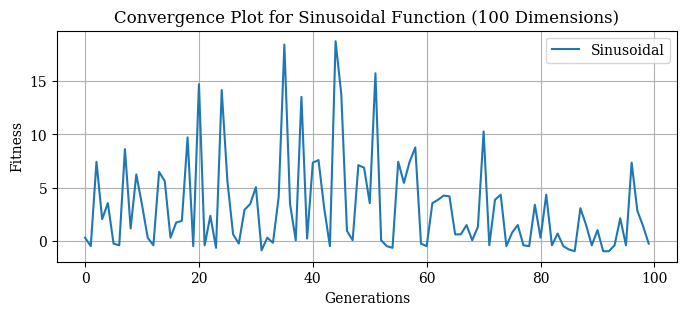

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(fitness_histories["Sinusoidal"], label="Sinusoidal")
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title("Convergence Plot for Sinusoidal Function (100 Dimensions)")
plt.legend()
plt.grid(True)
plt.show()

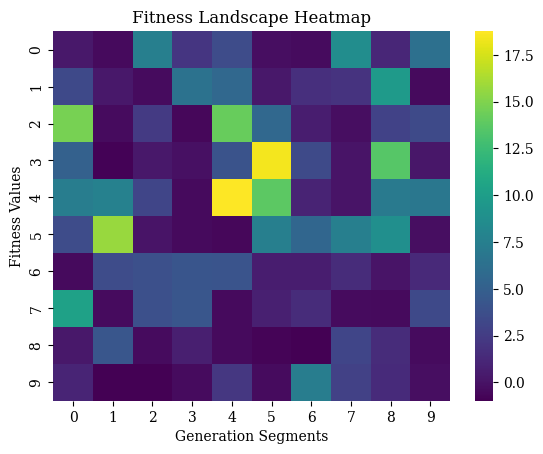

In [ ]:
fitness_matrix = np.array(fitness_histories["Sinusoidal"]).reshape(-1, 10)  # Adjust shape for visualization
sns.heatmap(fitness_matrix, cmap="viridis", annot=False)
plt.xlabel("Generation Segments")
plt.ylabel("Fitness Values")
plt.title("Fitness Landscape Heatmap")
plt.show()


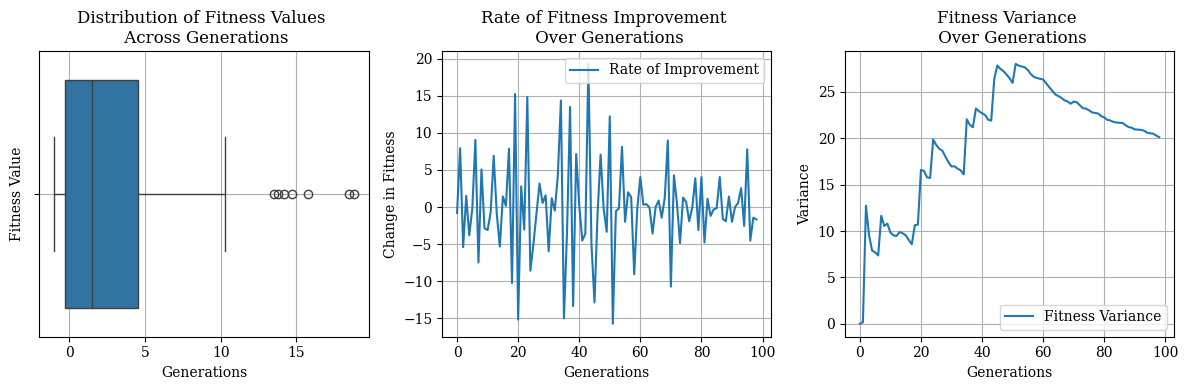

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Box Plot
sns.boxplot(x=fitness_histories["Sinusoidal"], ax=axs[0])
axs[0].set_xlabel("Generations")
axs[0].set_ylabel("Fitness Value")
axs[0].set_title("Distribution of Fitness Values \n Across Generations")
axs[0].grid()

# Rate of Improvement Plot
fitness_derivative = np.diff(fitness_histories["Sinusoidal"])
axs[1].plot(fitness_derivative, label="Rate of Improvement")
axs[1].set_xlabel("Generations")
axs[1].set_ylabel("Change in Fitness")
axs[1].set_title("Rate of Fitness Improvement \n Over Generations")
axs[1].legend()
axs[1].grid()

# Fitness Variance Plot
variance_fitness = [np.var(fitness_histories["Sinusoidal"][:i]) for i in range(1, len(fitness_histories["Sinusoidal"]))]
axs[2].plot(variance_fitness, label="Fitness Variance")
axs[2].set_xlabel("Generations")
axs[2].set_ylabel("Variance")
axs[2].set_title("Fitness Variance \n Over Generations")
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()